### Résumé
* Scores des soumissions jusqu'à présent: 2 modèles GB (jours travail + congés) < 1 modèle GB + 1 RF < 2 modèles GB Registered + Casual < 2 modèles GB + 2 RF < 1 modèle GB
* La recherche des hyperparamètres par GridSearchCV est très longue
* L'ajout des attributs "year", "month" et "day" n'a pas amélioré le score de soumission pour 1 modèle GB optimisé (0.44314 vs 0.44135 sans l'ajout)

## Importation de modules et RMSLE

In [1]:
import time
import pandas as pd  # provided data frames
import numpy as np
import matplotlib.pyplot as plt  # plotting support
import seaborn as sn  # plotting support
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
%matplotlib inline

In [2]:
def rmsle_log(y_real, y_pred):
    """Calcule la Root Mean Squared Logarithmic Error
    """
    y_real = np.exp(y_real)
    y_pred = np.exp(y_pred)
    total = 0.0
    for x in range(len(y_pred)):
        if y_pred[x] < 0: # log de valeurs négatives ne fonctionne pas
            p = 0
            r = np.log(y_real[x] + 1)
        elif y_real[x] < 0:  # Ne devrait jamais arrivé
            p = np.log(y_pred[x] + 1)
            r = 0
        else:
            p = np.log(y_pred[x] + 1)
            r = np.log(y_real[x] + 1)
        total = total + (p - r) ** 2
    return (total/len(y_pred)) ** 0.5

from sklearn.metrics import make_scorer
rmsle_log_score = make_scorer(rmsle_log, greater_is_better=False)

## Préparation des données

In [4]:
# Chargement des données
train = pd.read_csv("./train.csv", index_col="datetime")
initial_x_test = pd.read_csv("./test.csv", index_col="datetime")

# Conversion de l'index des dataframes de "str" à "Timestamp"
train.index = pd.to_datetime(train.index, infer_datetime_format=True)
initial_x_test.index = pd.to_datetime(initial_x_test.index, infer_datetime_format=True)
index_col = initial_x_test.index  # Series des dates de test pour la soumission à Kaggle

# Suppression des 147 valeurs aberrantes de count (optionnel)
train.drop(train[train["count"]>(train["count"].mean()+3*train["count"].std())].index, inplace=True)

# Séparation de l'ensemble d'entrainement attributs / cible
initial_x_train = train[train.columns[:-3]]
y_train = train["count"]
y_r = train["registered"]
y_c = train["casual"]

print("Nombre de données dans initial_x_train: {}".format(len(initial_x_train)))
print("Nombre de données dans initial_x_test: {}".format(len(initial_x_test)))
print("Nombre de données dans y_train: {}".format(len(y_train)))
initial_x_train.head()

Nombre de données dans initial_x_train: 10739
Nombre de données dans initial_x_test: 6493
Nombre de données dans y_train: 10739


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0


In [5]:
def modification_des_donnees(data):
    """Fonction pour modifier les ensembles de données selon la procédure déterminée durant le traitement
    """
    categories = ["year","month","day","hour","season","workingday","holiday","weather"]
    numeriques = ["atemp","humidity","windspeed"]
    
    new_data = data.copy(deep=True)
    
    new_data.drop("temp", axis=1, inplace=True)
    new_data.insert(0, "hour", new_data.index.hour)  # heure du jour de 0 à 23
    new_data["weather"].replace(to_replace=4, value=3, inplace=True)  # Lorsque weather = 4, remplacé par 3
    
    # Autres modifications potentielles
#     new_data.drop("holiday", axis=1, inplace=True)  # Retirer "holiday"
#     new_data.insert(0, "day", new_data.index.dayofweek + 1)  # Jour de la semaine (Lundi=1, Dimanche=7)
#     new_data.insert(0, "month", new_data.index.month)  # Ajouter le mois
#     new_data.insert(0, "year", new_data.index.year)  # Ajouter l'année
#     new_data.drop("windspeed", axis=1, inplace=True)  # Retirer "windspeed"
    
    for cat in categories:
        try:
            new_data[cat] = new_data[cat].astype("category")  # int -> category
        except KeyError:
            continue
    for num in numeriques:
        try:
            new_data[num] = new_data[num].astype("int64")  # float -> int
        except KeyError:
            continue
    
    return new_data

#### Traitement des données

In [22]:
x_train = modification_des_donnees(initial_x_train)
x_test = modification_des_donnees(initial_x_test)
y_log = np.log(y_train)  # pandas Series
y_log_r = np.where(y_r > 0, np.log(y_r), 0)  # array >donne quand même un warning de div par 0, mais c'est correct
y_log_c = np.where(y_c > 0, np.log(y_c), 0)  # array
attributes = x_train.columns  # Noms des attributs
print("Nombre de données dans x_train: {}".format(len(x_train)))
print("Nombre de données dans x_test: {}".format(len(x_test)))
print("Nombre de données dans y_train: {}".format(len(y_train)))
x_train.head()

Nombre de données dans x_train: 10739
Nombre de données dans x_test: 6493
Nombre de données dans y_train: 10739


/Applications/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Applications/Anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


,hour,season,holiday,workingday,weather,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-01 00:00:00,0,1,0,0,1,14,81,0
2011-01-01 01:00:00,1,1,0,0,1,13,80,0
2011-01-01 02:00:00,2,1,0,0,1,13,80,0
2011-01-01 03:00:00,3,1,0,0,1,14,75,0
2011-01-01 04:00:00,4,1,0,0,1,14,75,0


#### Séparations en deux groupes : Jours de travail et jours de fin de semaine + fériés (congés)

In [45]:
x_train_workday = x_train[x_train.workingday==1]
x_train_noworkday = x_train[(x_train.workingday==0) | (x_train.holiday==1)]

x_test_workday = x_test[x_test.workingday==1]
x_test_noworkday = x_test[(x_test.workingday==0) | (x_test.holiday==1)]

y_train_workday = y_train[x_train.workingday==1]
y_train_noworkday = y_train[(x_train.workingday==0) | (x_train.holiday==1)]

y_log_workday = np.log(y_train_workday)
y_log_noworkday = np.log(y_train_noworkday)

print("Nombre de données dans x_train_workday: {}".format(len(x_train_workday)))
print("Nombre de données dans x_train_noworkday: {}".format(len(x_train_noworkday)))
print("Somme des données dans x_train workday et noworkday: {}".format(len(x_train_workday) + len(x_train_noworkday)))
print("Somme des données dans x_test workday et noworkday: {}".format(len(x_test_workday) + len(x_test_noworkday)))
print("Somme des données dans y_train workday et noworkday: {}".format(len(y_train_workday) + len(y_train_noworkday)))

Nombre de données dans x_train_workday: 7268
Nombre de données dans x_train_noworkday: 3471
Somme des données dans x_train workday et noworkday: 10739
Somme des données dans x_test workday et noworkday: 6493
Somme des données dans y_train workday et noworkday: 10739


# Prédictions des modèles

### Fonctions utilitaires

In [24]:
def cv_score(model, x=x_train, y=y_train, scorer=rmsle_log):
    """Compute the cross-validation mean RMSLE error and return the predictions of the CV
    """
    predictions = cross_val_predict(model, x, y, cv=3)
    predictions = pd.Series([max(0, pred) for pred in predictions]).values
    score = scorer(y, predictions)
    print("Mean squared log error on cross-validation data: {0:.4f}".format(score))
    return predictions

In [25]:
def show_results(model, pred, y=y_log):
    """Afficher les résultats de CV et l'importance des attributs pour les modèles par ensemble
    """
    y = np.exp(y)
    plt.figure(figsize=(16, 6))
    
    # Plot predictions of CV vs true count values
    plt.subplot(1, 2, 1)
    plt.scatter(y, pred, edgecolors=(0, 0, 0))
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, attributes[sorted_idx])
    plt.xlabel('Importance Relative')
#     plt.title('Importance des Attributs')
    plt.show()

In [26]:
def show_test_distribution(pred, y=y_log):
    """Afficher la distribution des prédictions de la cible vs celle de l'ensemble d'entrainement
    """
    y = np.exp(y)
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1,2,1)
    sn.distplot(y, bins=50, axlabel="cible d'entraînement")
    plt.ylabel("Densité de probabilité")  # Estimation par noyau (KDE en anglais): l'aire sous la courbe est 1
    
    plt.subplot(1,2,2)
    sn.distplot(pred, bins=50, axlabel="cible prédite")
    plt.ylabel("Densité de probabilité")
    
    plt.show()

In [27]:
def find_hyperparameters(params, model, X=x_train.values, Y=y_log.ravel()):
    """Trouve les hyperparamètres d'un modèle pour obtenir le meilleur score RMSLE et retourne ce modèle
    """
    start = time.time()

    # Find best hyperparameters for the given params values
    gscv = GridSearchCV(model, params, cv=3, scoring=rmsle_log_score)
    gscv.fit(X, Y)

    print("Best RMSLE score : {}".format(gscv.best_score_))
    print("Best parameters for the model : {}".format(gscv.best_params_))
    
    end = time.time()
    print('Execution time : {0:.4f} seconds'.format(end-start))

    # Retourner le meilleur modèle
    return gscv.best_estimator_

In [28]:
def train_and_predict(model, X=x_train.values, Y=y_log.ravel(), test=x_test.values):
    """Entraîne un modèle, affiche les résultats de la validation croisée, affiche la distribution des prédictions
    et retourne les prédictions sur l'ensemble test
    """
    start = time.time()

    # Cross-Validation score and predictions
    predictions_cv_log = cv_score(model, x=X, y=Y, scorer=rmsle_log)
    predictions_cv = np.exp(predictions_cv_log)

    # Fit regression model
    model.fit(X, Y)

    end = time.time()
    print('Fitting and validation time : {0:.4f} seconds'.format(end-start))
    
    # Show CV results
    show_results(model, predictions_cv, y=Y)
    
    # Show distribution of predictions on test data
    pred_test = [max(0, x) for x in np.exp(model.predict(X=test))]
    show_test_distribution(pred_test, y=Y)
    
    return pred_test

## 1 Modèle GB

### Choix des paramètres

Meilleurs paramètres jusqu'à présent
* loss : huber (meilleur que les 3 autres)
* learning_rate : 0.15 (meilleur que 0.01, 0.05, 0.07, 0.1 et 0.2)
* n_estimators : 400 (meilleur que 200, 300, 500)
* max_depth : 3 (meilleur que 2, 4, 5 et 7)

In [99]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"loss":["huber"],  # ["ls", "lad", "huber", "quantile"]
          "learning_rate":[0.15, 0.2],
          "n_estimators":[400, 500],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[3],
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_gbr = find_hyperparameters(params=params, model=GradientBoostingRegressor())

Best RMSLE score : -0.5804549267551252
Best parameters for the model : {'learning_rate': 0.15, 'loss': 'huber', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Execution time : 28.2347 seconds


Best RMSLE score : -0.5799951540923958
Best parameters for the model : {'learning_rate': 0.15, 'loss': 'huber', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Execution time : 28.6737 seconds

### Entrainement, validation et prédictions

Mean squared log error on cross-validation data: 0.5845
Fitting and validation time : 7.5599 seconds


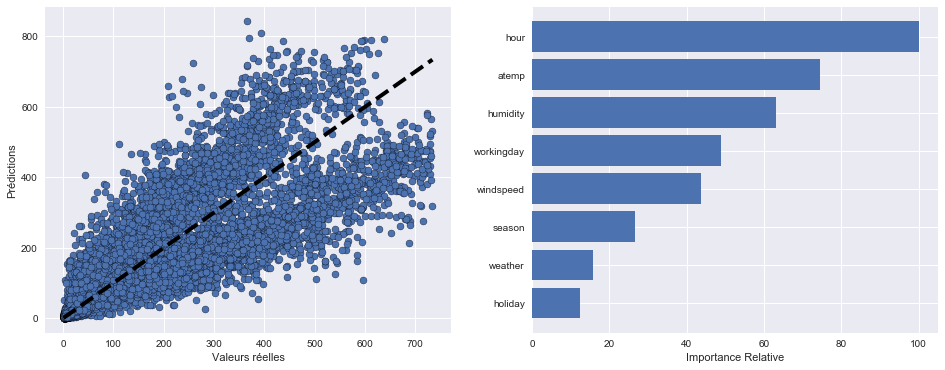

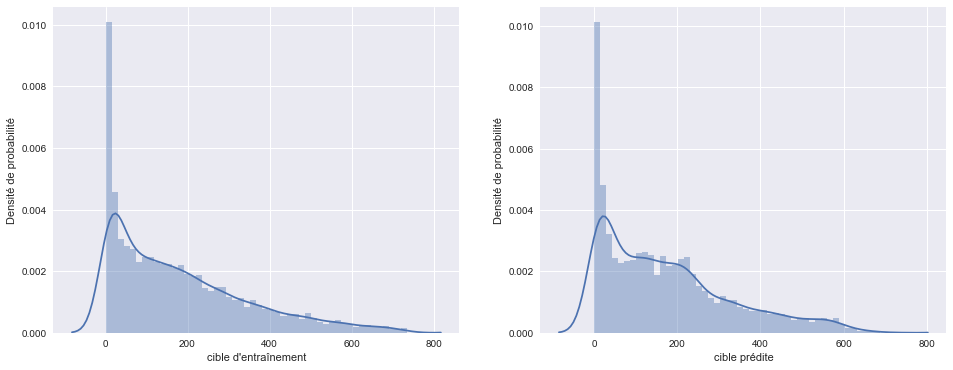

In [100]:
pred_test_gbr = train_and_predict(model=best_gbr)

### Soumission

In [90]:
soumission = pd.DataFrame(pred_test_gbr, columns=["count"], index=index_col)
soumission.to_csv("best_predictions.csv")

##### <span style="color:green">Résultat de la 1ere soumission avec 1 GB optimisé: 0.44135</span>
##### <span style="color:green">Résultat de la soumission avec 1 GB optimisé avec les attributs "year", "month" et "day": 0.44319</span>

## 2 Modèles : GB et RF

### Choix des paramètres pour RF (on garde les mêmes pour le modèle GB - voir étape précédente)

Meilleurs paramètres jusqu'à présent (ça prend bcp de temps avec n_estimators grand)
* criterion : mae (meilleur que mse)
* n_estimators : 30 ou 40 selon le cas (meilleur que 10, 20)
* max_features : auto
* max_depth : None (meilleur que 3)

In [71]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"criterion":["mae"],  # ["mse", "mae"]
          "n_estimators":[40],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[None], # None by default
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_rfr = find_hyperparameters(params=params, model=RandomForestRegressor())

Best RMSLE score : -0.6075286939199865
Best parameters for the model : {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
Execution time : 160.5215 seconds


Best RMSLE score : -0.6080251594507091
Best parameters for the model : {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Execution time : 234.0959 seconds

### Entrainement, validation et prédictions

Mean squared log error on cross-validation data: 0.6111
Fitting and validation time : 160.8178 seconds


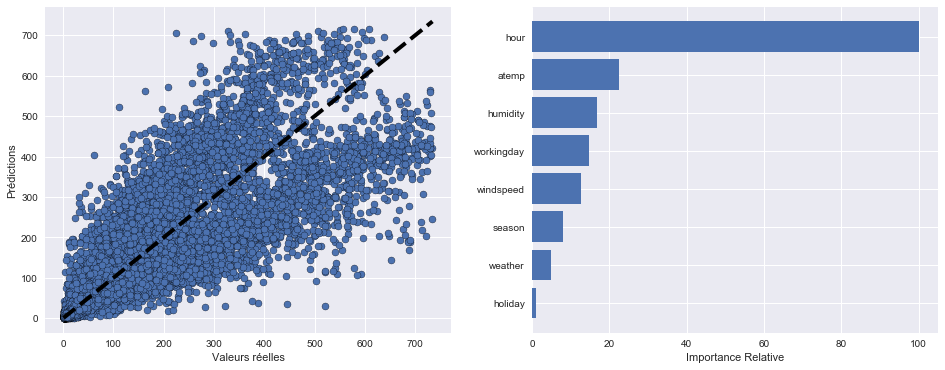

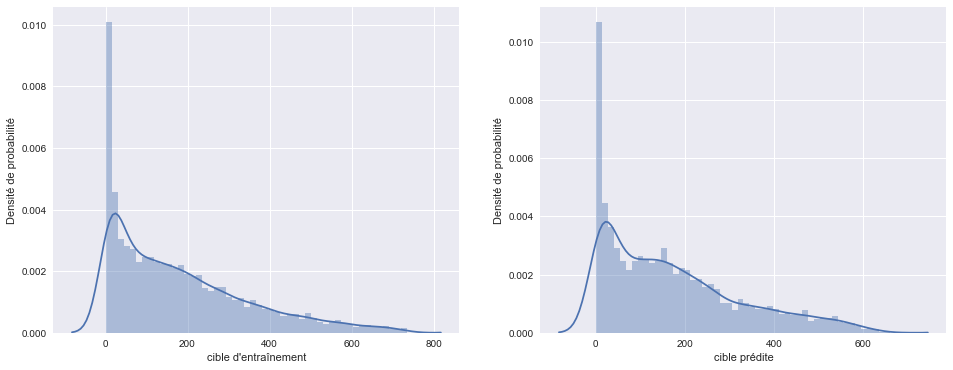

In [72]:
pred_test_rfr = train_and_predict(model=best_rfr)

### Mise en commun des prédictions

In [73]:
# Moyenne des prédictions des 2 modèles
pred_test = np.mean(np.array([pred_test_gbr, pred_test_rfr]), axis=0)
len(pred_test)

6493

### Soumission

In [35]:
soumission = pd.DataFrame(pred_test, columns=["count"], index=index_col)
soumission.to_csv("best_predictions.csv")

##### <span style="color:green">Résultat de la 1ere soumission avec GB et RF combinés: 0.43978</span>

## 2 Modèles GB : Jours de travail et Jours de congé

### Choix des paramètres

#### Modèle pour les jours de travail

Meilleurs paramètres jusqu'à présent
* loss : ls (meilleur que les 3 autres)
* learning_rate : 0.09 (meilleur que 0.01, 0.03, 0.05 à 0.08 et 0.1)
* n_estimators : 300 (meilleur que 200 ou 400)
* max_depth : 3 (meilleur que 2, 4, 5, 6, 7 et 8)

In [74]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"loss":["ls"],  # ["ls", "lad", "huber", "quantile"]
          "learning_rate":[0.09],
          "n_estimators":[300],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[3],
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_workday_gbr = find_hyperparameters(params=params, 
                                        model=GradientBoostingRegressor(), 
                                        X = x_train_workday.values, 
                                        Y = y_log_workday.ravel())

Best RMSLE score : -0.5629098733349938
Best parameters for the model : {'learning_rate': 0.09, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Execution time : 1.8305 seconds


Best RMSLE score : -0.5626826907221127
Best parameters for the model : {'learning_rate': 0.09, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Execution time : 7.8128 seconds

#### Modèle pour les jours de congé

Meilleurs paramètres jusqu'à présent
* loss : lad (meilleur que les 3 autres)
* learning_rate : 0.05 (meilleur que 0.01, 0.03, et 0.06 à 0.1) ***Ça change d'un test à l'autre***
* n_estimators : 200 (meilleur que 100 ou 300)
* max_depth : 7 (meilleur que 3, 5, 6 et 8)

In [75]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"loss":["lad"],  # ["ls", "lad", "huber", "quantile"]
          "learning_rate":[0.05],
          "n_estimators":[200],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[7],
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_noworkday_gbr = find_hyperparameters(params=params, 
                                          model=GradientBoostingRegressor(), 
                                          X = x_train_noworkday.values, 
                                          Y = y_log_noworkday.ravel())

Best RMSLE score : -0.6152438309593612
Best parameters for the model : {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 7, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Execution time : 7.4308 seconds


Best RMSLE score : -0.6117901988586878
Best parameters for the model : {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 7, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Execution time : 12.7850 seconds

### Entrainement, validation et prédictions

#### Modèles pour les jours de travail

Mean squared log error on cross-validation data: 0.5646
Fitting and validation time : 1.6496 seconds


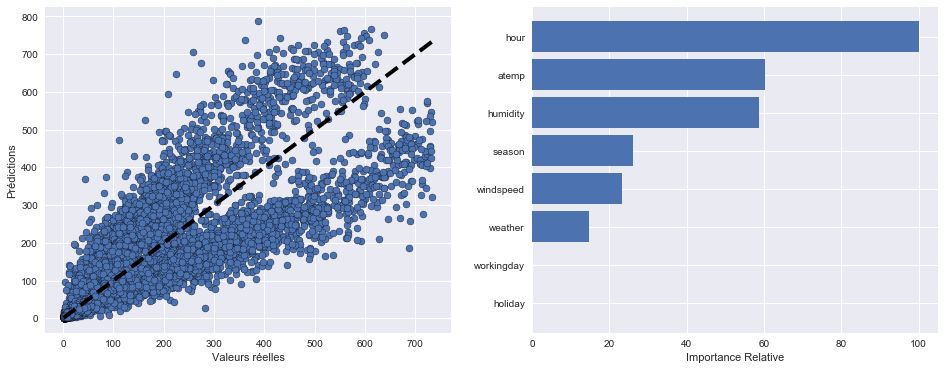

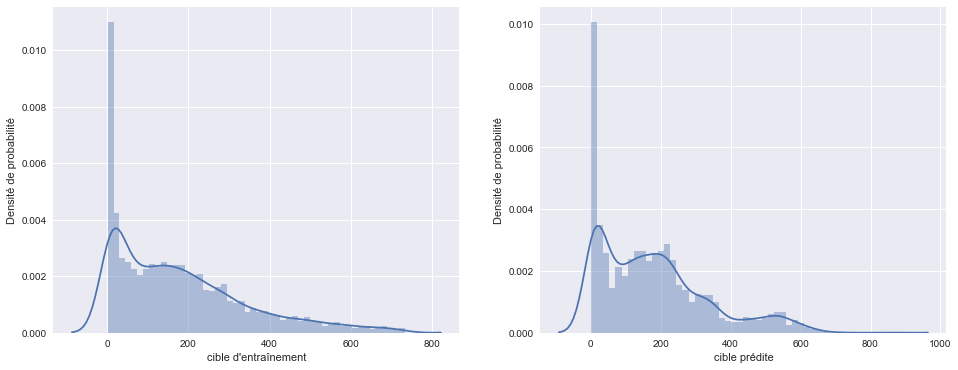

In [76]:
pred_workday = train_and_predict(model=best_workday_gbr, 
                                 X=x_train_workday.values, 
                                 Y=y_log_workday.ravel(), 
                                 test=x_test_workday.values)

#### Modèles pour les jours de congé

Mean squared log error on cross-validation data: 0.6237
Fitting and validation time : 7.4399 seconds


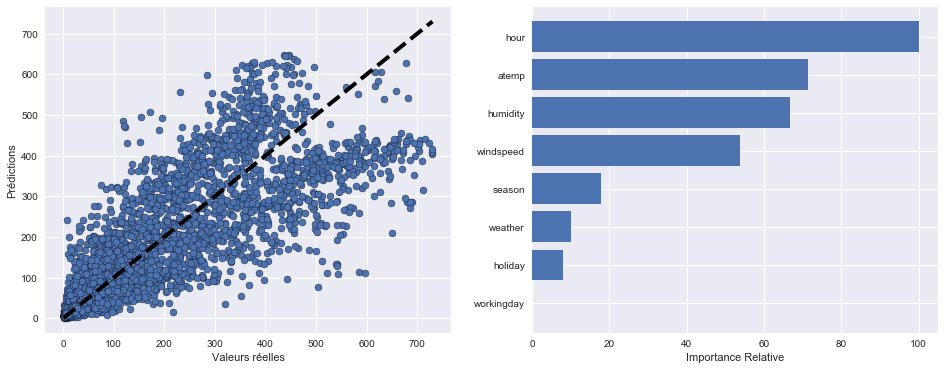

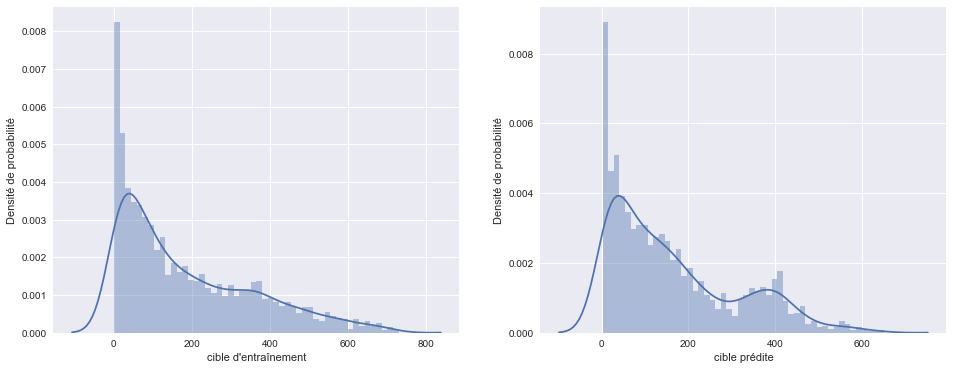

In [77]:
pred_noworkday = train_and_predict(model=best_noworkday_gbr, 
                                   X=x_train_noworkday.values, 
                                   Y=y_log_noworkday.ravel(), 
                                   test=x_test_noworkday.values)

### Mise en commun des prédictions

In [78]:
df1 = pd.DataFrame(pred_workday, columns=["count"], index=x_test_workday.index)
df2 = pd.DataFrame(pred_noworkday, columns=["count"], index=x_test_noworkday.index)
pred_test = pd.concat([df1, df2])
len(pred_test)  # Doit être = à 6493

6493

In [80]:
soumission = pd.DataFrame(pred_test, columns=["count"], index=index_col)
soumission.to_csv("best_predictions.csv")

##### <span style="color:green">Résultat de la 1ere soumission avec les 2 modèles GB combinés: 0.43697</span>

## 2 Modèles GB + 2 Modèles RF : Jours de travail et Jours de congé

### Choix des paramètres pour les 2 RF (on garde les mêmes que l'étape précédente pour les modèles GB)

#### Modèle pour les jours de travail

In [79]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"criterion":["mae"],  # ["mse", "mae"]
          "n_estimators":[20],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[None], # None by default
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_workday_rfr = find_hyperparameters(params = params, 
                                        model = RandomForestRegressor(), 
                                        X = x_train_workday.values, 
                                        Y = y_log_workday.ravel())

Best RMSLE score : -0.5922148311735056
Best parameters for the model : {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Execution time : 34.5559 seconds


Best RMSLE score : -0.5928248250596235
Best parameters for the model : {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Execution time : 64.5719 seconds

#### Modèle pour les jours de congé

In [80]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"criterion":["mae"],  # ["mse", "mae"]
          "n_estimators":[20],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[None], # None by default
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_noworkday_rfr = find_hyperparameters(params = params, 
                                          model = RandomForestRegressor(), 
                                          X = x_train_noworkday.values, 
                                          Y = y_log_noworkday.ravel())

Best RMSLE score : -0.6378561888393588
Best parameters for the model : {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Execution time : 8.6831 seconds


Best RMSLE score : -0.628615689194027
Best parameters for the model : {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Execution time : 27.7960 seconds

### Entrainement, validation et prédictions

#### Modèle pour les jours de travail

Mean squared log error on cross-validation data: 0.5966
Fitting and validation time : 34.2533 seconds


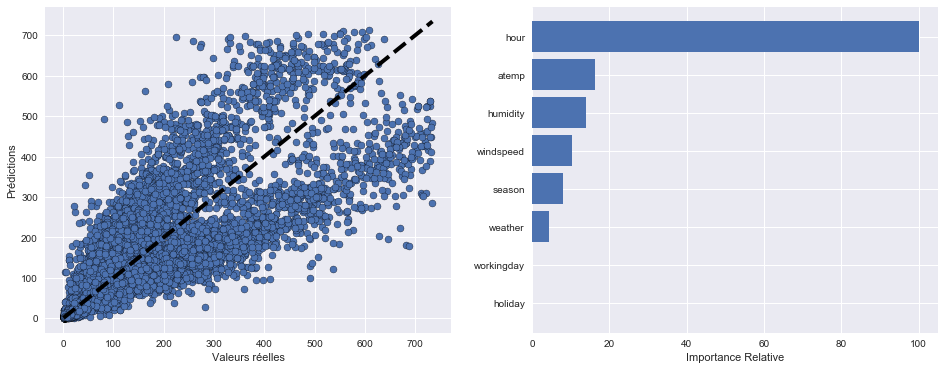

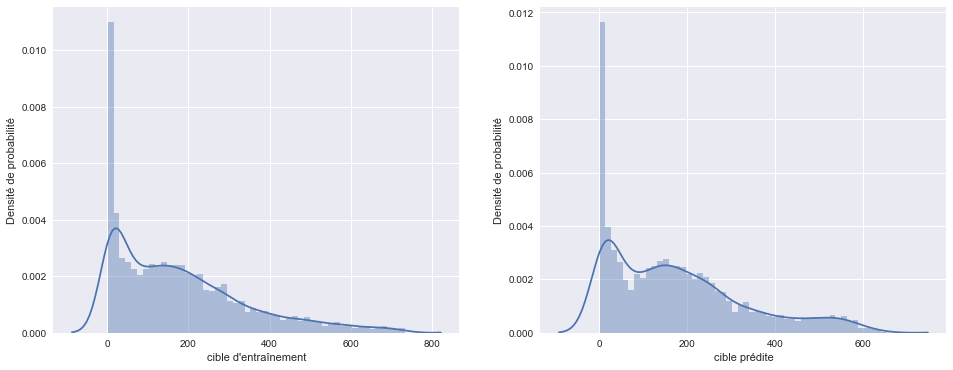

In [81]:
pred_workday_rfr = train_and_predict(model = best_workday_rfr, 
                                     X = x_train_workday.values, 
                                     Y = y_log_workday.ravel(), 
                                     test = x_test_workday.values)

#### Modèle pour les jours de congé

Mean squared log error on cross-validation data: 0.6447
Fitting and validation time : 8.4696 seconds


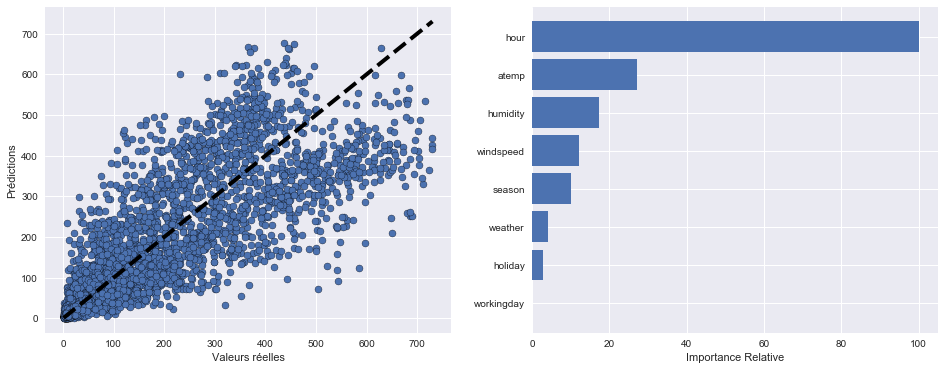

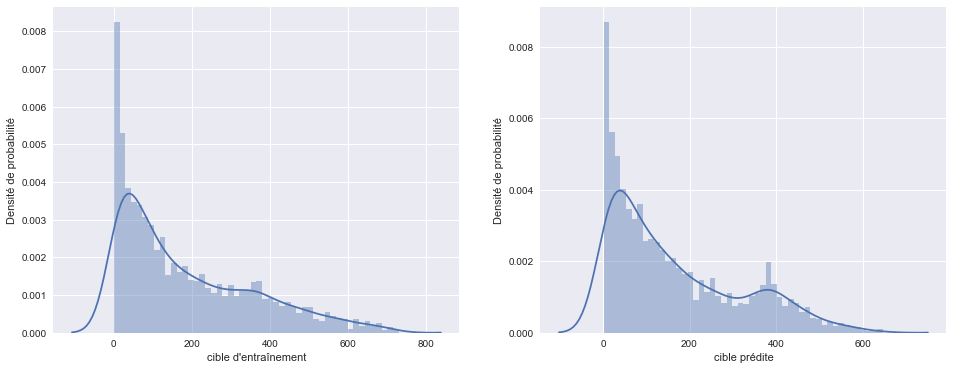

In [82]:
pred_noworkday_rfr = train_and_predict(model = best_noworkday_rfr, 
                                       X = x_train_noworkday.values, 
                                       Y = y_log_noworkday.ravel(), 
                                       test = x_test_noworkday.values)

### Mise en commun des prédictions

In [83]:
# Moyenne des prédictions des modèles GB + RF pour les jours de travail et de congé
pred_test_workday = np.mean(np.array([pred_workday, pred_workday_rfr]), axis=0)
pred_test_noworkday = np.mean(np.array([pred_noworkday, pred_noworkday_rfr]), axis=0)
print(len(pred_test_workday) + len(pred_test_noworkday))

6493


In [84]:
# Mise en commun des jours de travail et des jours de congé
df1 = pd.DataFrame(pred_test_workday, columns=["count"], index=x_test_workday.index)
df2 = pd.DataFrame(pred_test_noworkday, columns=["count"], index=x_test_noworkday.index)
pred_test = pd.concat([df1, df2])
len(pred_test)  # Doit être = à 6493

6493

In [32]:
soumission = pd.DataFrame(pred_test, columns=["count"], index=index_col)
soumission.to_csv("best_predictions.csv")

##### <span style="color:green">Résultat de la 1ere soumission avec les 4 modèles combinés: 0.44112</span>

## 2 Modèles GB : Registered + Casual

### Choix des paramètres

#### Modèle pour Registered

Meilleurs paramètres jusqu'à présent
* loss : ls (meilleur que les 3 autres)
* learning_rate : 0.1 (meilleur que 0.05, 0.08, 0.15 et 0.2)
* n_estimators : 400 (meilleur que 200, 300, 500)
* max_depth : 3 (meilleur que 5, 7)

In [34]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"loss":["ls"],  # ["ls", "lad", "huber", "quantile"]
          "learning_rate":[0.1, 0.15],
          "n_estimators":[400, 500],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[3, 7],
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_gbr_r = find_hyperparameters(params=params, model=GradientBoostingRegressor(), X=x_train.values, Y=y_log_r)

Best RMSLE score : -0.6020933625221891
Best parameters for the model : {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Execution time : 56.9082 seconds


Best RMSLE score : -0.6022912301225894
Best parameters for the model : {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Execution time : 79.9557 seconds

#### Modèle pour Casual

Meilleurs paramètres jusqu'à présent
* loss : ls (meilleur que les 3 autres)
* learning_rate : 0.15 (meilleur que 0.05, 0.08, 0.1 et 0.2)
* n_estimators : 200 (meilleur que 300, 400, 600)
* max_depth : 3 (meilleur que 5 et 7)

In [36]:
# Paramètres à déterminer pour obtenir le meilleur score. Voir la doc pour les détails.
params = {"loss":["ls"],  # ["ls", "lad", "huber", "quantile"]
          "learning_rate":[0.1, 0.15],
          "n_estimators":[200, 300],
          "max_features":["auto"],  # ["auto", "sqrt", "log2"]
          "max_depth":[3],
          "min_samples_split":[2],
          "min_samples_leaf":[1],
          "min_impurity_decrease":[0]}

# Sauvegarder le meilleur modèle
best_gbr_c = find_hyperparameters(params=params, model=GradientBoostingRegressor(), X=x_train.values, Y=y_log_c)

Best RMSLE score : -0.5715050730491612
Best parameters for the model : {'learning_rate': 0.15, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Execution time : 10.1817 seconds


Best RMSLE score : -0.5715050730491612
Best parameters for the model : {'learning_rate': 0.15, 'loss': 'ls', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Execution time : 10.1817 seconds

### Entrainement, validation et prédictions

#### Modèle pour Registered

Mean squared log error on cross-validation data: 0.6060
Fitting and validation time : 3.3849 seconds


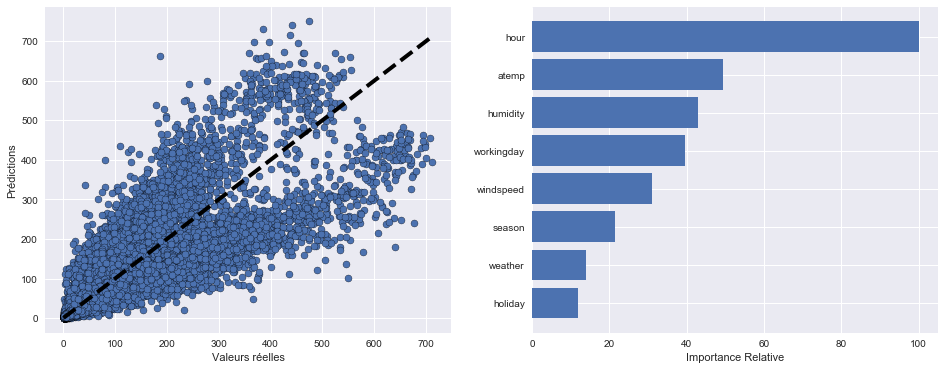

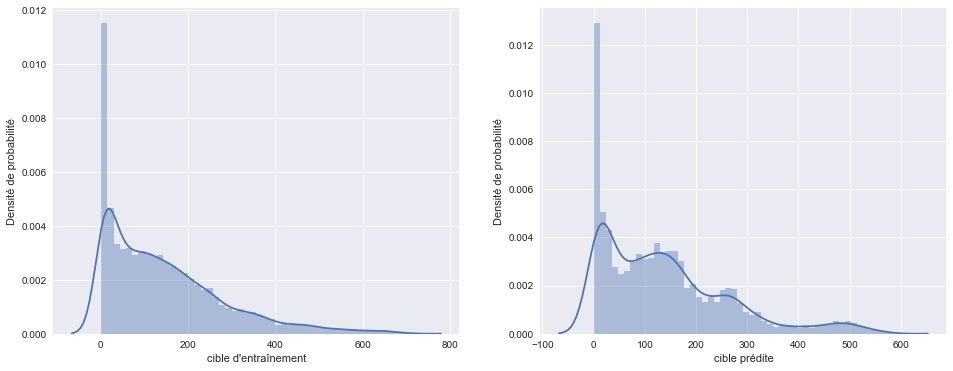

In [37]:
pred_test_gbr_r = train_and_predict(model=best_gbr_r, Y=y_log_r)

#### Modèle pour Casual

Mean squared log error on cross-validation data: 0.5714
Fitting and validation time : 1.6996 seconds


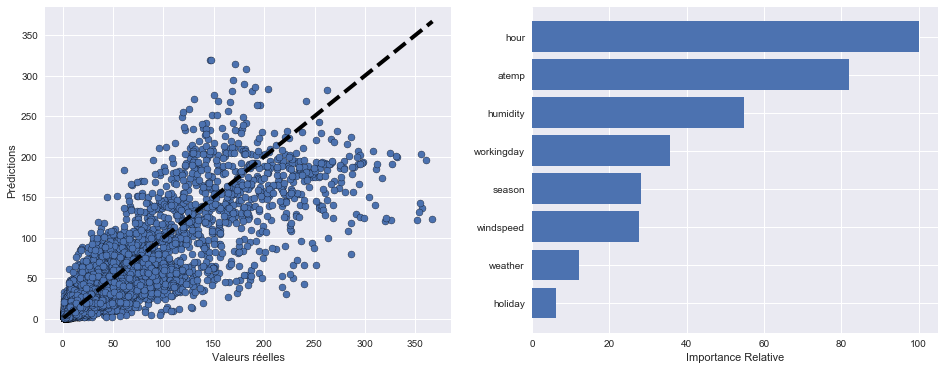

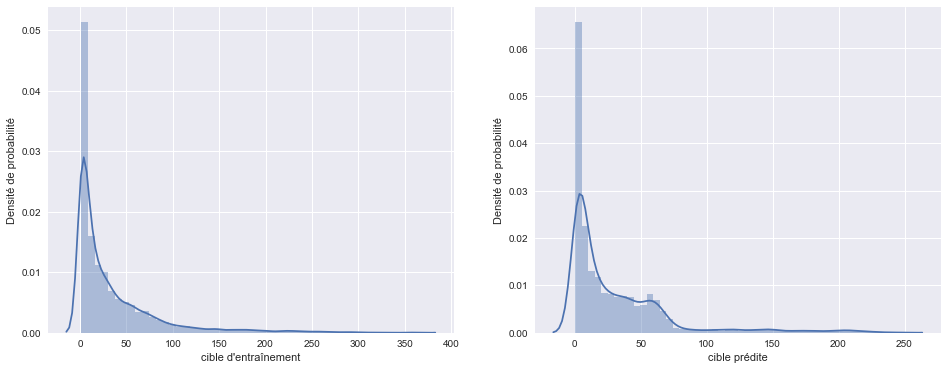

In [38]:
pred_test_gbr_c = train_and_predict(model=best_gbr_c, Y=y_log_c)

### Soumission

In [39]:
# Mise en commun de Registered et Casual
df1 = pd.DataFrame(pred_test_gbr_r, columns=["count"], index=x_test.index)
df2 = pd.DataFrame(pred_test_gbr_c, columns=["count"], index=x_test.index)
pred_test = df1 + df2  # Somme de Registered et Casual
len(pred_test)  # Doit être = à 6493

6493

In [44]:
soumission = pd.DataFrame(pred_test, columns=["count"], index=index_col)
soumission.to_csv("best_predictions.csv")

##### <span style="color:green">Résultat de la 1ere soumission avec 1 GB pour Registered et 1 pour Casual: 0.44031</span>